# Player Similarity Scores

Following up from **Predicting Map Difficulty with Score & Collaborative Filtering**, we now try to calculate similarity scores for all players

In [143]:
import warnings

import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import QuantileTransformer

from opal.conf.mods import OsuMod

# A false positive set by slice warning is shown, silence it
warnings.filterwarnings('ignore')
MAX_SCORE = 1e6

import pandas as pd

from opal.conf.conf import SCORES_DIR

df = pd.read_csv(SCORES_DIR / "top1k/raw.csv")

# Remove all scores with these mods.
mods_remove = OsuMod.DOUBLE_TIME | OsuMod.HALF_TIME | OsuMod.NIGHTCORE | OsuMod.EASY

df = df[~(df['enabled_mods'] & mods_remove > 0)]
df = df[['beatmap_id', 'user_id', 'score', 'year']]

# For some reason, we can have multiple scores on the same map with the same player.
# Here, we aggregate by taking their mean
df = df.groupby(['user_id', 'year', 'beatmap_id']).agg('mean').reset_index()

# Normalize scores to (0, 1)
df['score'] /= MAX_SCORE

# Uniformize Score
qt = QuantileTransformer()
df['score_transformed'] = qt.fit_transform(df[['score']])
df = df.set_index(['user_id', 'year'])

In [144]:
df.head()

beatmap_id     score  score_transformed
user_id year                                         
65724   2015      157152  0.412289           0.011070
        2015      310366  0.300932           0.004172
        2016       32840  0.456489           0.015098
        2016      437329  0.443105           0.013888
        2017       18875  0.523901           0.024580

We also implement the similarity curve fitting

In [145]:
def sigma_to_sim(sigma):
    """ Converts Sigma to Similarity Score """
    return float(np.exp(-np.abs(sigma)))


def curve_fn(x, sigma):
    """ Curve to fit to Player X Y performances """
    return x ** np.exp(sigma)


def fit_sigma(
    score_x: pd.Series, score_y: pd.Series
) -> float:
    """ Fits the x^e^s function to x, y scores """

    return curve_fit(curve_fn, score_x, score_y)[0]

We firstly yield all unique "users".
Note that we assume that improvements happen every year, so we deem a `user_id` unique per year.

Thus, we split by `user_id` and `year`.

In [146]:
MIN_PLAYS_PER_MONTH = 1000
MIN_COMMON_PLAYS = 40
# We group by the Year & User ID
# A Group will thus contain a user's score for a year
gb = df.groupby(df.index)

# We remove all groups smaller than MIN_PLAYS_PER_MONTH
gb = list(filter(lambda g: len(g[1]) > MIN_PLAYS_PER_MONTH, gb))

user_ids = [g[0] for g in gb]
user_n = len(user_ids)
dfs_scores = [g[1] for g in gb]
df_scores = pd.concat(dfs_scores)

In [147]:
from tqdm import tqdm
from itertools import combinations
import seaborn as sns

# Prep the similarity array to be filled
index = pd.MultiIndex.from_tuples(user_ids, names=["user_id", "year"])
ar_sim = np.empty([user_n, user_n], dtype=float)
ar_sim[:] = np.nan
df_sim = pd.DataFrame(columns=index, index=index, data=ar_sim)
df_sim.index.set_names(['user_id', 'year'])

gb_pair = combinations(gb, 2)
pair_n = int(user_n * (user_n - 1) / 2)

for (pxi, df_px), (pyi, df_py) in tqdm(gb_pair, total=pair_n):
    # Find common maps played
    df_p = df_px.merge(df_py, on='beatmap_id')

    # If common maps < MIN_COMMON_PLAYS
    if len(df_p) < MIN_COMMON_PLAYS: continue

    score_x, score_y = df_p['score_transformed_x'], df_p['score_transformed_y']

    # Calculate Sigma & Similarity Score
    sigma = fit_sigma(score_x, score_y)
    df_sim.loc[pxi, pyi] = sigma_to_sim(sigma)

# Reflect on diagonal
df_sim[df_sim.isna()] = df_sim.T

100%|██████████| 5778/5778 [00:22<00:00, 254.30it/s]


Let's take a look at the similarity as a heatmap

<AxesSubplot:xlabel='user_id-year', ylabel='user_id-year'>

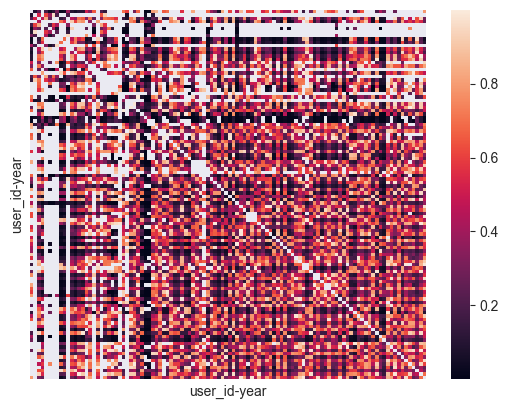

In [148]:
sns.heatmap(df_sim, yticklabels=False, xticklabels=False)

Great! We have the similarity matrix (as a DataFrame) to compare.
As a quick example let's find a user with a good amount of similarities.
This should give us a good spread!

In [149]:
user = df_sim.isna().sum(axis=0).sort_values(ascending=True).index[0]
print("Chosen User ID / Year ", user)

Chosen User ID / Year  (12064488, 2018)


Text(0.5, 1.0, 'Spread of Players Similarity for (12064488, 2018)')

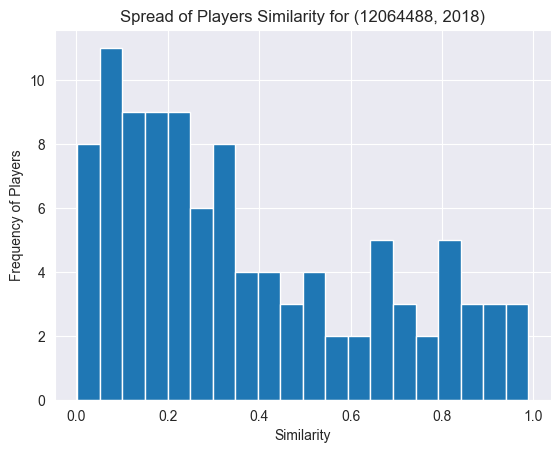

In [150]:
import matplotlib.pyplot as plt

user_df = df_sim.loc[user]
user_df.hist(bins=20)
plt.xlabel("Similarity")
plt.ylabel("Frequency of Players")
plt.title(f"Spread of Players Similarity for {user}")

Excellent! It looks like a good spread

Next, take a score with a good amount of shared player plays against that player

In [151]:
# Sorry if it's looks messy

bid = (
    # Get intersection of scores that the user has played
    df_scores[df_scores['beatmap_id'].isin(df_scores.loc[user, 'beatmap_id'])]
    # Count beatmap players
    .groupby('beatmap_id')
    .agg('count')
    # Get the series
    .iloc[:, 0]
    # Sort by most played first
    .sort_values(ascending=False)
    # Get most played (beatmap_id) key
    .index[0]
)

We have 2 scores, 1 untransformed, one transformed.
We'll predict the transformed score, then inverse transform it to see its error!

The next step is to get all scores from the same beatmap from other players

In [152]:
df_score_sim = df_scores[df_scores['beatmap_id'] == bid].merge(
    # Merge with similarity on the pid, year key
    df_sim[user].rename('similarity'),
    left_index=True, right_index=True
).sort_values(by='similarity', ascending=False)
# NA Scores come from those with no similarity (including self-similarity)
df_score_sim = df_score_sim.dropna()
df_score_sim

,,beatmap_id,score,score_transformed,similarity
user_id,year,,,,
5179995,2017,532798,0.814012,0.171857,0.935321
6522146,2016,532798,0.812101,0.169481,0.924161
13975661,2021,532798,0.873285,0.268128,0.869636
9630674,2017,532798,0.621331,0.046252,0.818271
10242770,2018,532798,0.781440,0.136064,0.809893
5818319,2017,532798,0.817678,0.177013,0.797778
15929931,2021,532798,0.844420,0.217505,0.784330
8911771,2017,532798,0.730292,0.093892,0.769283
11778716,2019,532798,0.715069,0.085311,0.737978


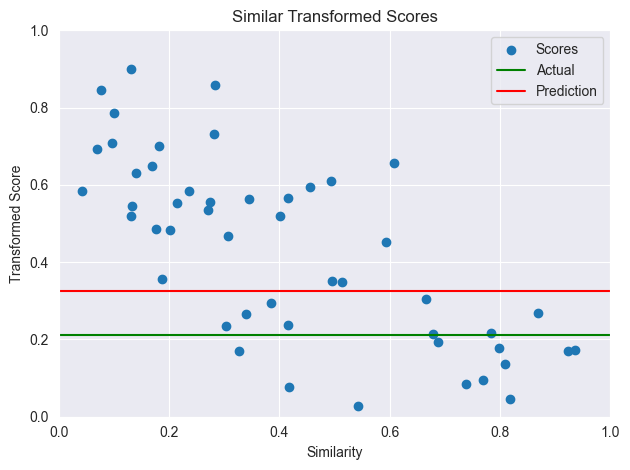

In [153]:
plt.scatter(df_score_sim['similarity'], df_score_sim['score_transformed'], label='Scores')
plt.xlabel("Similarity")
plt.ylabel("Transformed Score")
plt.xlim(0, 1)
plt.ylim(0, 1)
actual_qt = float(
    df_scores.loc[
        (df_scores.index == user) &
        (df_scores['beatmap_id'] == bid), 'score_transformed']
)
predict_qt = np.average(df_score_sim['score_transformed'],
                     weights=df_score_sim['similarity'])
_ = plt.title("Similar Transformed Scores")
_ = plt.axhline(actual_qt, color='green', label='Actual')
_ = plt.axhline(predict_qt, color='red', label='Prediction')
_ = plt.legend()
_ = plt.tight_layout()

Interestingly, we see another trend, players similar tend to have similar scores (as expected).

Let's take the weighted average, then compute the error of it

In [154]:
predict = qt.inverse_transform([[predict_qt]])[0, 0]
actual = qt.inverse_transform([[actual_qt]])[0, 0]
error = (predict - actual) * 1e6
print("Actual/Predict/Difference",
      round(actual * MAX_SCORE),
      round(predict* MAX_SCORE),
      round(error)
      )

Actual/Predict/Difference 840061 901261 61200


## Summary

We illustrated how can use our previously found similarity function to perform similarity matching.

We also ran this pipeline against 1 example to illustrate its steps.

Next, we'll scale this up !